# Unsupervised Sentiment Analysis using GMM

Extracting Tf-Idf feature vector from the given movie review dataset and
Using GMM and EM algorithm to perform Unsupervised Sentiment Analysis

Libraries used:
1) Numpy - for numerical computations such as fft(), dot operator
2) Scipy - to find the likelihood of data points
3) Matplotlib - to plot the spectogram

In [1]:
import numpy as np
import string, re, random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Function preprocess_text()

Gets the vocabulary of words from the given text dataset

Strips the sentences into individual words

In [2]:
vocabulary = []
target = []
words_count = []
reviews = []

def preprocess_text(filename):
    split_by_char =[':', '/']
    
    with open(filename, "r") as f:
        line_number = 0
        for line in f.readlines():
            review = []
            words = line.split(" ")

            word_count = 0
            for word in words[:-1]: 
                if word == "" or word == " " or word in string.punctuation:
                    continue

                word = word.strip(")(.*-&?:;, ")

                for char in split_by_char:
                    if char in word:
                        word2 = word.split(char)
                        for word in word2:
                            if word.lower() not in vocabulary:
                                vocabulary.append(word.lower())
                            word_count += 1
                            review.append(word.lower())
                else:
                    if word.lower() not in vocabulary:
                        vocabulary.append(word.lower())
                    review.append(word.lower())
                    word_count += 1
            line_number += 1

            words_count.append(word_count)
            if "0" in words[-1]:
                target.append(0)
                review.append(0)
            else:
                target.append(1)
                review.append(1)
            reviews.append(review)

In [3]:
preprocess_text("movieReviews1000.txt")
print("Number of unique words in vocabulary: ", len(vocabulary))

Number of unique words in vocabulary:  3165


#### Qs 4) a) Extracting Tf-Idf features per each word

### Function calculate_idf()

Calculates the Inverse Document Frequency values
for each word in the vocabulary

In [4]:
def calculate_idf(documents, vocabulary):
    
    idf = np.zeros((len(vocabulary), 1))
    
    n=len(documents)
    l = 0
    
    for word in vocabulary:
        word_count=0
        for words in documents:
            if word in words:
                word_count+=1
                
        idf[l]=(np.log((1+n)/(word_count+1)))
        l+=1
    return idf

### Function calculate_tf_idf()

Calculates the Term Frequency and Tf_Idf values
for each word and document in the given text dataset

In [5]:
def calculate_tf_idf(idf):
    tf_idf = np.zeros((len(vocabulary), 0))
    
    line = 0
    for review in reviews:
        tf =  np.zeros((len(vocabulary), 1))
        
        for word in review[:-1]:
            idx = vocabulary.index(word)
            tf[idx] += 1
        
        tf = (tf+1) / (2*len(review))
        line += 1
        tf_idf = np.hstack((tf_idf, tf))
    
    tf_idf_matrix = tf_idf * idf
    
    
    return tf_idf_matrix

In [6]:
idf = calculate_idf(reviews, vocabulary)
tf_idf = calculate_tf_idf(idf)
print("Size of the input feature matrix: ", tf_idf.shape)

Size of the input feature matrix:  (3165, 1000)


#### Qs 4) b) Performing PCA 

To reduce the dimension of the given data

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

dim_red_tf_idf = pca.fit_transform(tf_idf.T)

print(dim_red_tf_idf.shape)

(1000, 10)


In [8]:
class KMeans():
    def __init__(self, n_clusters, max_iter, tol = 0.0001):
        self.n_clusters = n_clusters
        self.max_iter   = max_iter
        self.tol        = tol
        
    # X - shape (n_samples, n_features)
    def fit(self, X):

        self.centroid = [np.random.rand(X.shape[1], X.shape[1]) for i in range(self.n_clusters)]
        
        data_points = random.sample(range(X.shape[0]), self.n_clusters)
        
        for i in range(self.n_clusters):
            self.centroid[i] = X[data_points[i]]
        
        epsilon = self.tol + 1
        for i in range(self.max_iter):
            
            if epsilon < self.tol:
                break
            
            self.clusters = [[] for i in range(self.n_clusters)]
            
            for sample in X:
                idx = np.argmin(np.array([np.linalg.norm(self.centroid[k] - sample) for k in range(self.n_clusters)])) 
                self.clusters[idx].append(sample)
            
            previous_centroid = self.centroid[:]
            
            epsilon = 0
            for j in range(self.n_clusters):
                
                if len(self.clusters[j]) == 0:
                    continue
                    
                self.centroid[j] = np.mean(np.array(self.clusters[j]), axis = 0)

                err = abs(self.centroid[j] - previous_centroid[j])
                epsilon = max(epsilon, sum(err))


#### Initializing the mean and covariance for EM iteration using KMeans clustering

In [9]:
n_mixtures_ = 2
covariance_type = 'diag'

clf = KMeans(n_clusters=2, max_iter = 100)

clf.fit(dim_red_tf_idf)

mu_k = [clf.centroid[0], clf.centroid[1]]
sigma_k = [[] for i in range(n_mixtures_)]

for i in range(n_mixtures_):
    sigma_k[i] = np.cov(np.array(clf.clusters[i]).T)

if covariance_type == 'diag':
    for i in range(n_mixtures_):
        diag = np.einsum('ii->i', sigma_k[i])
        save = diag.copy()
        sigma_k[i][...] = 0
        sigma_k[i] = np.diag(save)

#### Question 4) c) Training 2 mixture diagonal covariance GMM 

In [10]:
class GMM:
    def __init__(self, n_mixtures, max_iter, covariance_type, tol = 0.0001):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.tol = tol
        self.covariance_type = covariance_type
        
    def initialize(self, mean, sigma):
        self.alpha = [(1/self.n_mixtures) for i in range(self.n_mixtures)]
        self.mean  = mean
        self.sigma = sigma
        
    def expectation_step(self, X):
        self.likelihood_data = self.predict_likelihood(X)
        
    def maximization_step(self, X):
        self.alpha = np.mean(self.predict_likelihood(X), axis=0)
        
        for i in range(self.n_mixtures):
            like_prob = self.likelihood_data[:, i]
            num = X * like_prob.reshape((X.shape[0], 1))
            self.mean[i]  = np.sum(num, axis = 0) / np.sum(like_prob)
            
            cov = like_prob.reshape((1, X.shape[0])) * (X - self.mean[i]).T
            cov = cov.dot((X - self.mean[i]))
            cov /= np.sum(like_prob)
            self.sigma[i] = cov
            
            if self.covariance_type == 'diag':
                for i in range(n_mixtures_):
                    diag = np.einsum('ii->i', sigma_k[i])
                    save = diag.copy()
                    sigma_k[i][...] = 0
                    sigma_k[i] = np.diag(save)

    def predict_likelihood(self, X):
        likelihood = np.zeros( (X.shape[0], self.n_mixtures))
        
        for i in range(self.n_mixtures):
            distribution = multivariate_normal(mean=self.mean[i], cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
            
        likelihood_gmm = likelihood * self.alpha
        total_likelihood = likelihood_gmm.sum(axis=1)[:, np.newaxis]
        likelihood_gmm = likelihood_gmm / total_likelihood
        return likelihood_gmm
    
    def calc_log_likelihood(self, X):
        likelihood = np.zeros( (X.shape[0], self.n_mixtures) )
        for i in range(self.n_mixtures):
            distribution = multivariate_normal(
                mean=self.mean[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.alpha
        log_like = np.log(np.sum(numerator, axis=1))
        log_like = np.sum(log_like)
        return log_like
    
    def plot_data(self, X):
        pred = self.predict(X)
        count = len([0 for i in pred if i == 1])
        print("Data points with maximum likelihood on Gaussian Mixture component 1: ", count)
        print("Data points with maximum likelihood on Gaussian Mixture component 2: ", 1000 -count)
        for i in range(X.shape[0]):
            if pred[i] == 1:
                plt.scatter(X[i][0], X[i][1], color='r')
            elif pred[i] == 0:
                plt.scatter(X[i][0], X[i][1], color='b')
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()
        
    # X - n_samples, n_features
    def fit(self, X):
        log_likelihood = []
        
        #last = self.max_iter
        
        for i in range(self.max_iter):
            self.expectation_step(X)
            self.maximization_step(X)
            
            print("Iteration: ", i+1)
            self.plot_data(X)
            
            log_likelihood.append(self.calc_log_likelihood(X))
            if i > 2 and abs(abs(log_likelihood[-1]) - abs(log_likelihood[-2])) < self.tol:
                print("------ EM Iteration Converged ------")
                break
        
        #plt.scatter([i for i in range(last)], log_likelihood, marker="o", color='g', linewidths=5)  
        #plt.show()
        
    def predict(self, X):
        weights = self.predict_likelihood(X)
        return np.argmax(weights, axis=1)

(1000, 10)
Iteration:  1
Data points with maximum likelihood on Gaussian Mixture component 1:  817
Data points with maximum likelihood on Gaussian Mixture component 2:  183


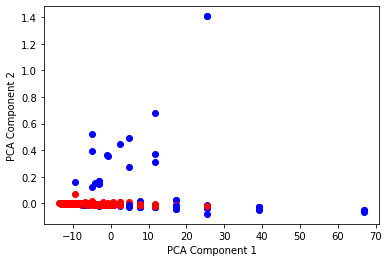

Iteration:  2
Data points with maximum likelihood on Gaussian Mixture component 1:  810
Data points with maximum likelihood on Gaussian Mixture component 2:  190


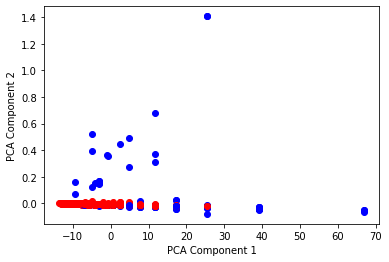

Iteration:  3
Data points with maximum likelihood on Gaussian Mixture component 1:  805
Data points with maximum likelihood on Gaussian Mixture component 2:  195


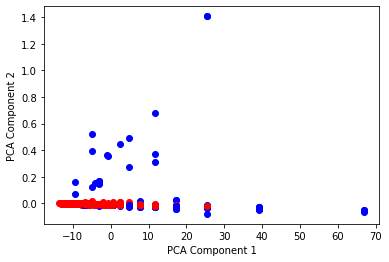

Iteration:  4
Data points with maximum likelihood on Gaussian Mixture component 1:  802
Data points with maximum likelihood on Gaussian Mixture component 2:  198


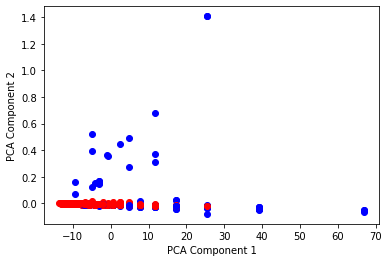

Iteration:  5
Data points with maximum likelihood on Gaussian Mixture component 1:  802
Data points with maximum likelihood on Gaussian Mixture component 2:  198


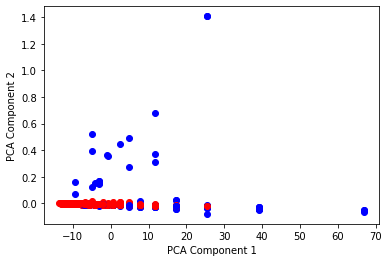

Iteration:  6
Data points with maximum likelihood on Gaussian Mixture component 1:  800
Data points with maximum likelihood on Gaussian Mixture component 2:  200


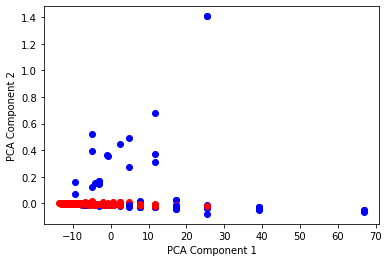

Iteration:  7
Data points with maximum likelihood on Gaussian Mixture component 1:  800
Data points with maximum likelihood on Gaussian Mixture component 2:  200


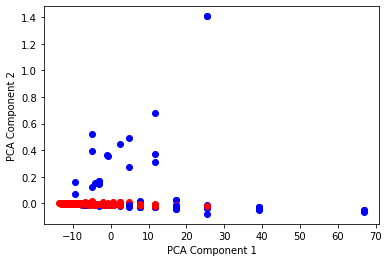

Iteration:  8
Data points with maximum likelihood on Gaussian Mixture component 1:  800
Data points with maximum likelihood on Gaussian Mixture component 2:  200


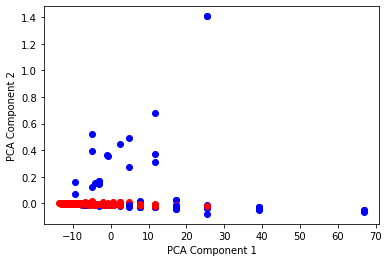

Iteration:  9
Data points with maximum likelihood on Gaussian Mixture component 1:  800
Data points with maximum likelihood on Gaussian Mixture component 2:  200


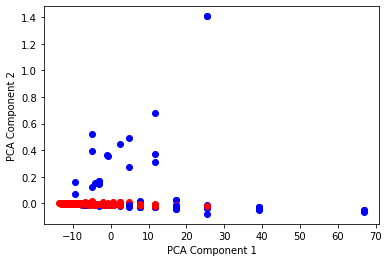

Iteration:  10
Data points with maximum likelihood on Gaussian Mixture component 1:  800
Data points with maximum likelihood on Gaussian Mixture component 2:  200


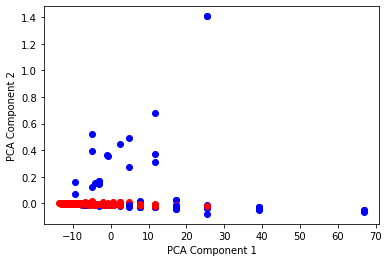

Iteration:  11
Data points with maximum likelihood on Gaussian Mixture component 1:  799
Data points with maximum likelihood on Gaussian Mixture component 2:  201


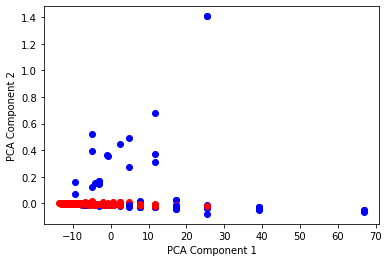

Iteration:  12
Data points with maximum likelihood on Gaussian Mixture component 1:  799
Data points with maximum likelihood on Gaussian Mixture component 2:  201


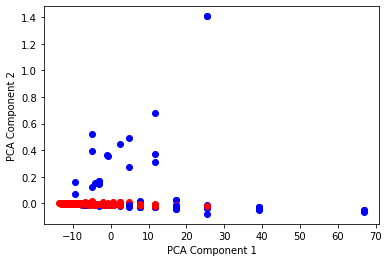

Iteration:  13
Data points with maximum likelihood on Gaussian Mixture component 1:  799
Data points with maximum likelihood on Gaussian Mixture component 2:  201


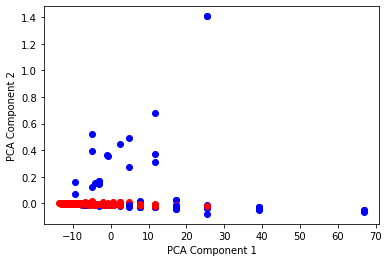

Iteration:  14
Data points with maximum likelihood on Gaussian Mixture component 1:  799
Data points with maximum likelihood on Gaussian Mixture component 2:  201


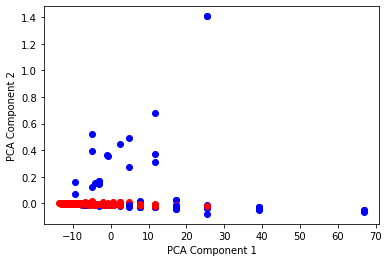

------ EM Iteration Converged ------


In [11]:
gmm = GMM(n_mixtures = n_mixtures_, max_iter = 40, covariance_type = covariance_type)
print(dim_red_tf_idf.shape)
gmm.initialize(mu_k, sigma_k)
gmm.fit(dim_red_tf_idf)

#### Question 4) d) Misprediction Rate

In [12]:
pred = gmm.predict(dim_red_tf_idf)

error = 0
for i in range(1000):
    if target[i] != pred[i]:
        error += 1
misclassification_percent = min(error, dim_red_tf_idf.shape[0] - error) / dim_red_tf_idf.shape[0] * 100

print("Misclassification Percent: ", misclassification_percent,"%")

Misclassification Percent:  45.9 %


#### No, the true label does not correlates properly with the cluster identity
#### On average, there is a 45.9 % mismatch between true label and cluster identity